# Reformulate Method Evaluation

This notebook evaluates the Reformulate query expansion method (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets, comparing against baseline.

## How to Run

1. Press "Run All" to execute all cells
2. All required files will be created automatically if missing
3. Metrics and plots will be saved to `data/evaluate/reformulate/`


In [ ]:
# Setup: imports and path configuration
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Notebook is located at notebook/reformulate.ipynb
project_root = Path.cwd().parents[0]

# Define core configuration
datasets = ["trec_covid", "climate_fever"]
retrieval_methods = ["bm25", "tfidf"]
method_name = "reformulate"
data_base = project_root / "data"

auto_run_max_queries = None  # set to an int (e.g. 50) to limit LLM calls

sys.path.insert(0, str(project_root / "src"))

from evaluate import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs,
)
from evaluate.utils import (
    ensure_directory,
    find_top_delta_queries,
    create_summary_table,
)
from notebook.run_api import ensure_runs

from expand.expander import TogetherQueryExpander, ExpansionStrategy

print("Setup complete! Project root:", project_root)

/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/.venv/lib/python3.10/site-packages/beir/datasets/data_loader.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Setup complete! Project root: /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms


## Ensure ingest outputs and method runs

This will:
- Ensure ingested artifacts exist under `data/ingest/{dataset}`
- Ensure baseline runs exist under `data/retrieve/baseline/`
- Expand the real dataset queries using Together
- Run retrieval (BM25 + TF-IDF) for the expanded queries and save to `data/retrieve/reformulate/`

In [2]:
ensure_directory(data_base / "retrieve" / method_name)
ensure_directory(data_base / "evaluate" / method_name)

# Ensure baseline runs exist
baseline_runs = ensure_runs(method="baseline", datasets=datasets, retrieval_methods=retrieval_methods, top_k=100)
print("\nBaseline runs ensured:\n", json.dumps(baseline_runs, indent=2, default=str))

# Instantiate expander (requires API_KEY in environment or .env)
expander = TogetherQueryExpander(strategy=ExpansionStrategy.REFORMULATE)

# Ensure method runs exist
method_runs = ensure_runs(
    method=method_name,
    expander=expander,
    datasets=datasets,
    retrieval_methods=retrieval_methods,
    top_k=100,
    max_queries=auto_run_max_queries,
)
print(f"{method_name} runs ensured:\n", json.dumps(method_runs, indent=2, default=str))

=== Dataset: trec_covid ===
Loaded pre-tokenized data for faster retrieval
[trec_covid / bm25] Run already exists and is valid at /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/baseline/trec_covid_bm25.csv
[trec_covid / tfidf] Run already exists and is valid at /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/baseline/trec_covid_tfidf.csv
=== Dataset: climate_fever ===
Loaded pre-tokenized data for faster retrieval
[climate_fever / bm25] Run already exists and is valid at /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/baseline/climate_fever_bm25.csv
[climate_fever / tfidf] Run already exists and is valid at /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/baseline/climate_fever_tfidf.csv

Baseline runs ensured:
 {
  "trec_covid": {
    "bm25": "/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/baseline/trec_covid_bm25.csv",
 

Processing queries: 100%|██████████| 1535/1535 [17:03:43<00:00, 40.02s/it]  


[climate_fever / bm25] Saved run to /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/climate_fever_bm25.csv
[climate_fever / tfidf] Running retrieval (tfidf)...
Building TF-IDF index...


Building TF-IDF index: 100%|██████████| 5416593/5416593 [04:04<00:00, 22157.08doc/s]


Retrieving results...


Processing queries: 100%|██████████| 1535/1535 [6:38:30<00:00, 15.58s/it]  


[climate_fever / tfidf] Saved run to /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/climate_fever_tfidf.csv
reformulate runs ensured:
 {
  "trec_covid": {
    "bm25": "/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/trec_covid_bm25.csv",
    "tfidf": "/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/trec_covid_tfidf.csv"
  },
  "climate_fever": {
    "bm25": "/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/climate_fever_bm25.csv",
    "tfidf": "/home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/retrieve/reformulate/climate_fever_tfidf.csv"
  }
}


## Compute Metrics for All 4 Combos


In [3]:
# Compute metrics for reformulate method runs
all_metrics = {}

for dataset in datasets:
    qrels_path = data_base / "ingest" / dataset / "qrels.csv"

    for retrieval in retrieval_methods:
        run_path = data_base / "retrieve" / method_name / f"{dataset}_{retrieval}.csv"
        metric_path = data_base / "evaluate" / method_name / f"{dataset}_{retrieval}.csv"

        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(metric_path),
            dataset=dataset,
            method=method_name,
            retrieval=retrieval,
        )

        all_metrics[(dataset, method_name, retrieval)] = metrics
        print(f"{retrieval} × {dataset}: nDCG@10={metrics['ndcg@10']:.4f}, MAP={metrics['map']:.4f}")

print("\nMetrics computation complete!")

bm25 × trec_covid: nDCG@10=0.2165, MAP=0.2336
tfidf × trec_covid: nDCG@10=0.0849, MAP=0.1089
bm25 × climate_fever: nDCG@10=0.0715, MAP=0.0908
tfidf × climate_fever: nDCG@10=0.0166, MAP=0.0274

Metrics computation complete!


## Compare with Baseline


In [4]:
# Compare reformulate method with baseline (statistical test on nDCG@10)
comparison_results = []

for dataset in datasets:
    qrels_path = data_base / "ingest" / dataset / "qrels.csv"

    for retrieval in retrieval_methods:
        run_path = data_base / "retrieve" / method_name / f"{dataset}_{retrieval}.csv"
        baseline_run_path = data_base / "retrieve" / "baseline" / f"{dataset}_{retrieval}.csv"

        stats = compare_runs(
            str(baseline_run_path),
            str(run_path),
            str(qrels_path),
            metric="ndcg@10",
            k=10,
        )

        comparison_results.append(
            {
                "dataset": dataset,
                "retrieval": retrieval,
                "baseline_mean": stats["baseline_mean"],
                "reformulate_mean": stats["system_mean"],
                "difference": stats["mean_difference"],
                "p_value": stats["p_value"],
                "ci_lower": stats.get("ci_lower"),
                "ci_upper": stats.get("ci_upper"),
            }
        )

        print(f"{retrieval} × {dataset}: Δ={stats['mean_difference']:.4f}, p={stats['p_value']:.4f}")

comparison_df = pd.DataFrame(comparison_results)
print("\nComparison Summary:")
print(comparison_df.to_string(index=False))

pvals_path = data_base / "evaluate" / method_name / "pvals.json"
ensure_directory(pvals_path.parent)
with open(pvals_path, "w", encoding="utf-8") as f:
    json.dump({"method": method_name, "comparisons": comparison_results}, f, indent=2)
print(f"\nP-values and CIs saved to: {pvals_path}")

bm25 × trec_covid: Δ=-0.1484, p=0.0002
tfidf × trec_covid: Δ=-0.1057, p=0.0022
bm25 × climate_fever: Δ=-0.0171, p=0.0001
tfidf × climate_fever: Δ=-0.0087, p=0.0001

Comparison Summary:
      dataset retrieval  baseline_mean  reformulate_mean  difference  p_value  ci_lower  ci_upper
   trec_covid      bm25       0.364900          0.216549   -0.148351 0.000167 -0.221916 -0.080537
   trec_covid     tfidf       0.190612          0.084926   -0.105686 0.002210 -0.166333 -0.042608
climate_fever      bm25       0.088584          0.071464   -0.017120 0.000131 -0.026203 -0.008955
climate_fever     tfidf       0.025235          0.016572   -0.008663 0.000075 -0.012686 -0.004564

P-values and CIs saved to: /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/evaluate/reformulate/pvals.json


## Summary and Top Delta Queries


In [5]:
# Create summary table
summary_df = create_summary_table(all_metrics)
summary_path = data_base / "evaluate" / method_name / "summary.csv"
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))
print(f"\nSaved to: {summary_path}")

# Show top delta queries for one example
dataset_example = datasets[0]
retrieval_example = retrieval_methods[0]

qrels = load_qrels_file(str(data_base / "ingest" / dataset_example / "qrels.csv"))
baseline_run = load_run_file(str(data_base / "retrieve" / "baseline" / f"{dataset_example}_{retrieval_example}.csv"))
method_run = load_run_file(str(data_base / "retrieve" / method_name / f"{dataset_example}_{retrieval_example}.csv"))

baseline_scores = compute_per_query_metric(baseline_run, qrels, metric="ndcg@10", k=10)
method_scores = compute_per_query_metric(method_run, qrels, metric="ndcg@10", k=10)

top_positive, top_negative = find_top_delta_queries(baseline_scores, method_scores, top_n=10)

print(f"\nTop 5 Positive Δ (nDCG@10) - {retrieval_example} × {dataset_example}:")
for qid, delta in top_positive[:5]:
    print(f"  {qid}: +{delta:.4f}")

print(f"\nTop 5 Negative Δ (nDCG@10) - {retrieval_example} × {dataset_example}:")
for qid, delta in top_negative[:5]:
    print(f"  {qid}: {delta:.4f}")

Summary Metrics Table:
      dataset      method retrieval  ndcg@10      map  recall@100      mrr
   trec_covid reformulate      bm25 0.216549 0.233649    0.029920 0.414702
   trec_covid reformulate     tfidf 0.084926 0.108895    0.012401 0.182466
climate_fever reformulate      bm25 0.071464 0.090786    0.255983 0.107628
climate_fever reformulate     tfidf 0.016572 0.027400    0.157058 0.031467

Saved to: /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/evaluate/reformulate/summary.csv

Top 5 Positive Δ (nDCG@10) - bm25 × trec_covid:
  3: +0.3817
  41: +0.3590
  8: +0.2572
  18: +0.2114
  16: +0.1431

Top 5 Negative Δ (nDCG@10) - bm25 × trec_covid:
  23: -0.4206
  33: -0.4284
  14: -0.4304
  13: -0.4401
  27: -0.4421


## Plot nDCG@10 Comparison


Plot saved to: /home/iailab42/lakracha0/domain-specific-query-expansion-with-llms/data/evaluate/reformulate/ndcg.png


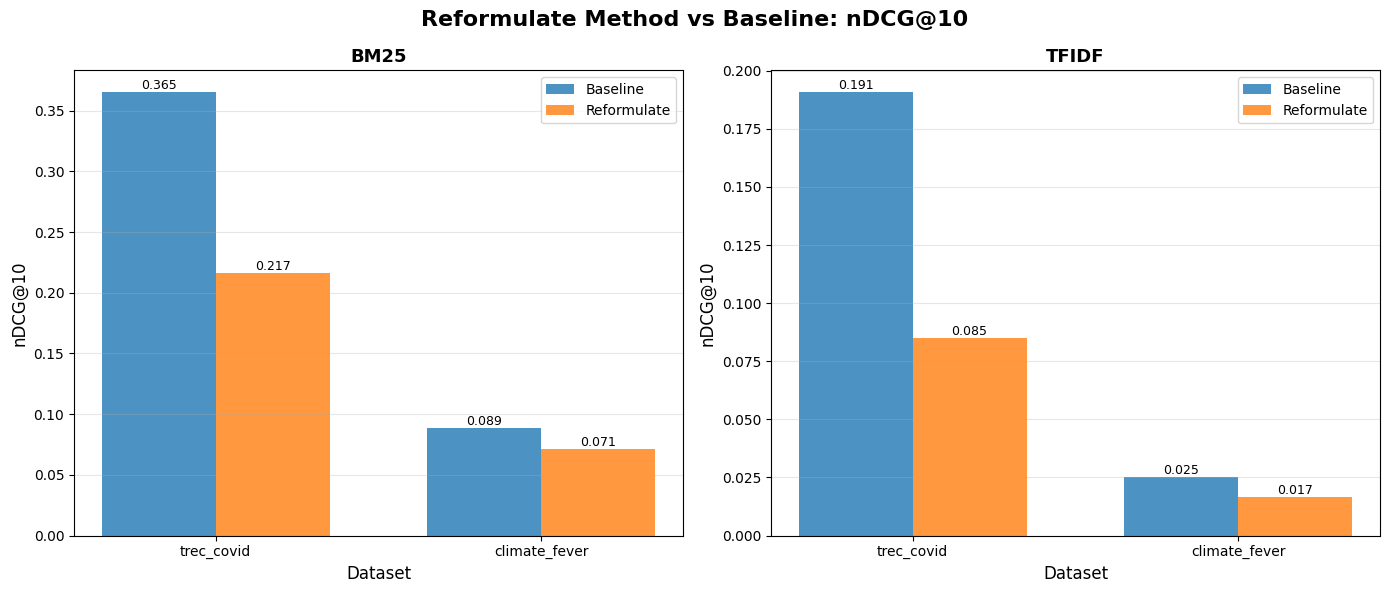

In [6]:
# Plot nDCG@10 comparison (baseline vs reformulate)
from evaluate.compute_metrics import compute_metrics_from_files as load_metrics

baseline_metrics = {}
for dataset in datasets:
    for retrieval in retrieval_methods:
        qrels_path = data_base / "ingest" / dataset / "qrels.csv"
        baseline_run_path = data_base / "retrieve" / "baseline" / f"{dataset}_{retrieval}.csv"
        baseline_metrics[(dataset, retrieval)] = load_metrics(str(baseline_run_path), str(qrels_path), k=10)

fig, axes = plt.subplots(1, len(retrieval_methods), figsize=(14, 6), squeeze=False)
fig.suptitle("Reformulate Method vs Baseline: nDCG@10", fontsize=16, fontweight="bold")

for idx, retrieval in enumerate(retrieval_methods):
    ax = axes[0][idx]
    x = np.arange(len(datasets))
    width = 0.35

    baseline_scores = [baseline_metrics[(d, retrieval)]["ndcg@10"] for d in datasets]
    method_scores = [all_metrics[(d, method_name, retrieval)]["ndcg@10"] for d in datasets]

    bars1 = ax.bar(x - width / 2, baseline_scores, width, label="Baseline", alpha=0.8)
    bars2 = ax.bar(x + width / 2, method_scores, width, label="Reformulate", alpha=0.8)

    ax.set_xlabel("Dataset", fontsize=12)
    ax.set_ylabel("nDCG@10", fontsize=12)
    ax.set_title(f"{retrieval.upper()}", fontsize=13, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

plt.tight_layout()
plot_path = data_base / "evaluate" / method_name / "ndcg.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Plot saved to: {plot_path}")
plt.show()